In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np


,Date,Segment_id,x,y,Evapotranspiration,Precipitation,Irrigation_pumping,Observed,group_id
0,708479,256,1941550,14524320,1.96,18.9,0.0,13.52459,0


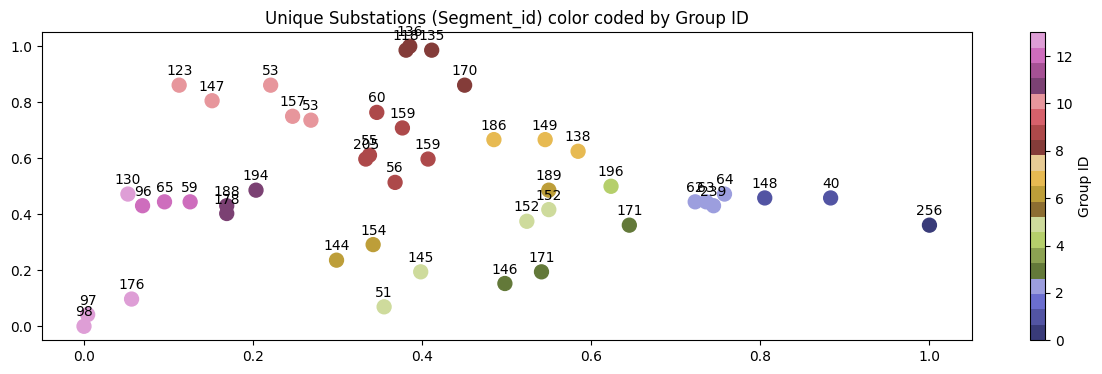

In [11]:
"""
Group stations based on geographic location according to the map in the document 
Grouping is found in the file Segment_group_id.csv
"""

df = pd.read_csv('data/RRCA_baseflow.csv')
group_ids = pd.read_csv('data/Segment_group_id.csv')
df = df.merge(group_ids, on='Segment_id', how="right")
display(df.head(1))
df.to_csv('data/RRCA_baseflow_grouped.csv', index=False)

df = df[['group_id', 'Segment_id', 'x', 'y']].drop_duplicates().reset_index(drop=True)
df['x'] = MinMaxScaler().fit_transform(df[['x']])
df['y'] = MinMaxScaler().fit_transform(df[['y']])
# display(df.head(1))

group_num = df['group_id']
y_text_offset = -0.05

plt.figure(figsize=(15, 4))
plt.title('Unique Substations (Segment_id) color coded by Group ID')
plt.scatter(df['x'], df['y'], c=group_num, cmap='tab20b', s=100)
for i, txt in enumerate(df['Segment_id']):
    plt.text(df.at[i, 'x'], df.at[i, 'y']-y_text_offset, str(txt), fontsize=10, color='black', ha='center', va='center')

plt.colorbar(label='Group ID')
plt.show()



In [12]:
""" 
    Preprocess the data
    - clean the date column to workable format
    - standardize the features and observed baseflow
    - 
"""
df = pd.read_csv('data/RRCA_baseflow_grouped.csv')
# df = pd.read_csv('data/RRCA_baseflow.csv')
features = ['Evapotranspiration', 'Precipitation', 'Irrigation_pumping']
target = ['Observed']

# Convert the weird date (number of days) to a datetime object. We only care about the month
df['Date'] = df['Date'].apply(lambda x: x-693963)
df['Date'] = pd.to_datetime(df['Date'], unit='D', origin='1900-01-01')
# df = df[df['Date'] > '1960-01-01']
df.sort_values(by='Date', inplace=True)
df['Date'] = df['Date'].dt.to_period('M')

# Standardize the data
scaler = StandardScaler()
df[features + target] = scaler.fit_transform(df[features + target])

# Take only group 13 for testing. Average the stations for each month
df = df[df['group_id'] == 13]
df = df.groupby(['group_id', 'Date']).mean().reset_index()

# # Fill in missing months with the average value of the previous and next month
min_date = df['Date'].min()
max_date = df['Date'].max()
all_months = pd.period_range(start=min_date, end=max_date, freq='M')
all_months = pd.DataFrame(all_months, columns=['Date'])
merged = pd.merge(all_months, df, on='Date', how='left')
merged = merged.fillna(method='ffill')

# Remove outliers beyond 3 standard deviations
for feature in features + target:
    df = df[np.abs(df[feature]) < 3]


merged.to_csv('data/RRCA_grouped.csv', index=False)

In [13]:
""" Iterate over each group, and calculate the average correlation"""
df = pd.read_csv(f'data/RRCA_grouped.csv')
df = df.set_index('Date')
corr_values = df[features + target].corr()['Observed']
corr_values.drop('Observed', inplace=True)
evaporation = -corr_values[0]
precipitation = corr_values[1]
irrigation = corr_values[2]
total = evaporation + precipitation + irrigation
print(f'total_correlation: {round(total, 3)}')

total_correlation: 0.571


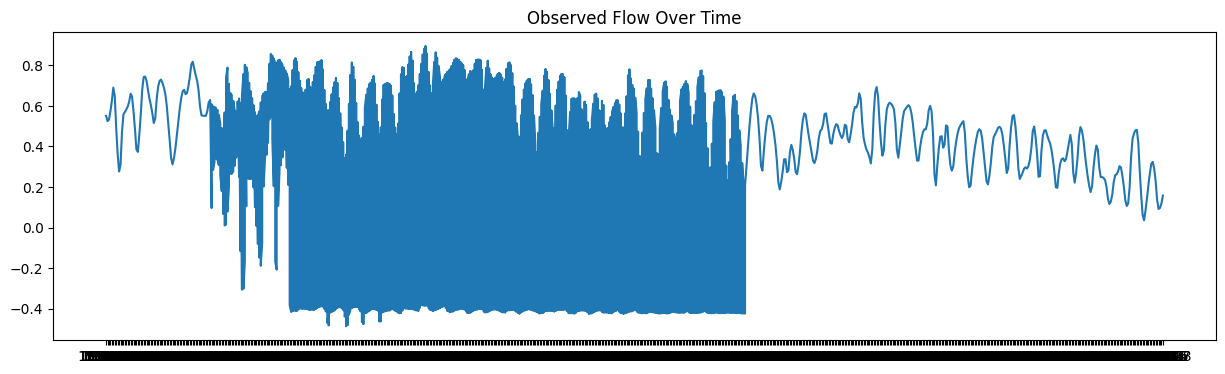

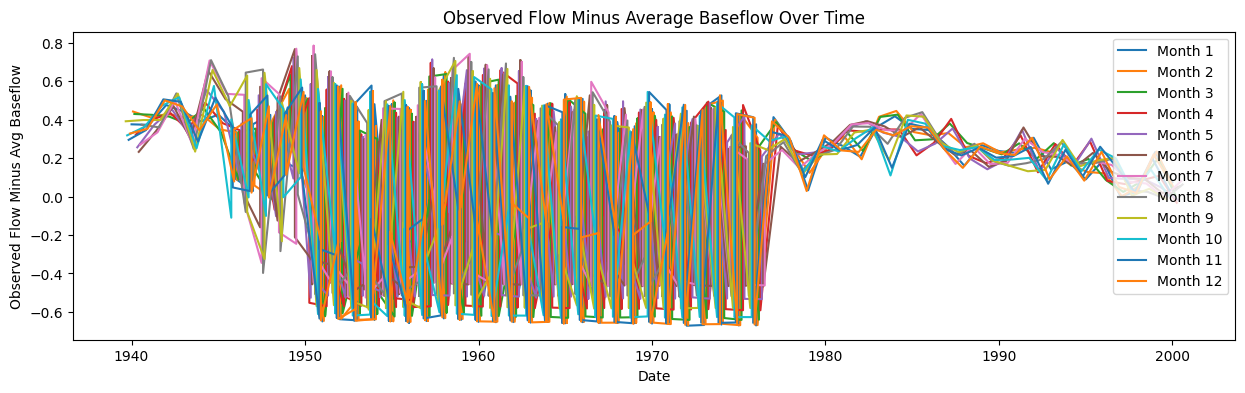

In [14]:
""" Plot the observed flow for the entire dataset over time"""
df = pd.read_csv('data/RRCA_grouped.csv')
plt.figure(figsize=(15, 4))
plt.title('Observed Flow Over Time')
plt.plot(df['Date'], df['Observed'])
plt.show()

# Get the average baseflow for each month
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
monthly_avg = df.groupby('Month')['Observed'].mean().reset_index()
monthly_avg.columns = ['Month', 'AvgBaseflow']

# Merge monthly averages with the main dataframe
df = df.merge(monthly_avg, on='Month')
df['ObservedMinusAvg'] = df['Observed'] - df['AvgBaseflow']

# Plot observed flow minus average baseflow for each month
plt.figure(figsize=(15, 4))
plt.title('Observed Flow Minus Average Baseflow Over Time')

# Plot each month's data separately
for month, month_data in df.groupby('Month'):
    plt.plot(month_data['Date'], month_data['ObservedMinusAvg'], label=f'Month {month}')

plt.xlabel('Date')
plt.ylabel('Observed Flow Minus Avg Baseflow')
plt.legend()
plt.show()

df.to_csv('data/RRCA_grouped_monthly_avg.csv', index=False)

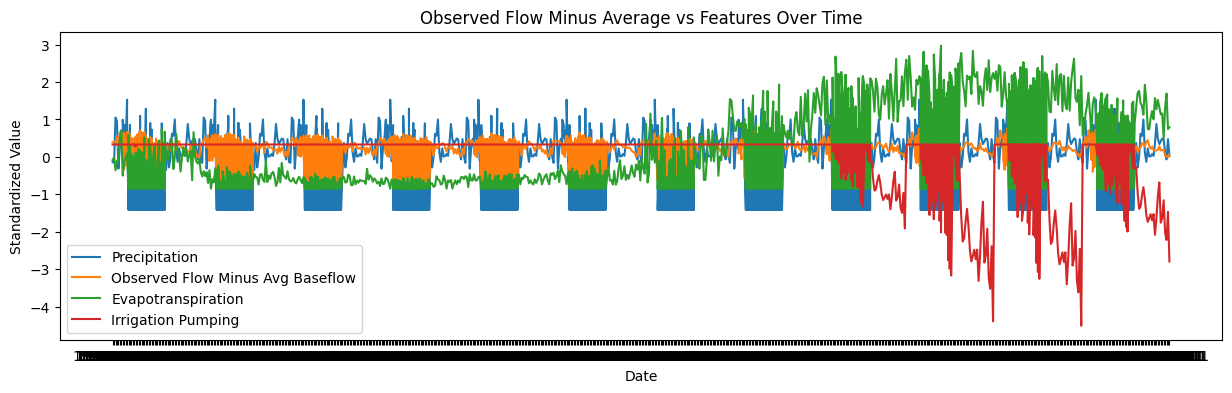

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/RRCA_grouped_monthly_avg.csv')
plt.figure(figsize=(15, 4))
plt.title('Observed Flow Minus Average vs Features Over Time')

plt.plot(df['Date'], df['Precipitation'], label='Precipitation')
plt.plot(df['Date'], df['ObservedMinusAvg'], label='Observed Flow Minus Avg Baseflow')
plt.plot(df['Date'], df['Evapotranspiration'], label='Evapotranspiration')
plt.plot(df['Date'], df['Irrigation_pumping'], label='Irrigation Pumping')

plt.xlabel('Date')
plt.ylabel('Standardized Value')
plt.legend()
plt.show()


In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

""" Now with our cleaned data, perform Linear Regression on the entire dataset """

class Model:
    def __init__(self, df, feature_cols, target_col):
        self.df = df
        self.feature_cols = feature_cols
        self.target_col = target_col
        self.model = LinearRegression()

    def predict(self, X_test):
        return self.model.predict(X_test)
    
    def score(self, cv=5):
        # Perform cross-validation and print cross-validated R^2 scores
        cv_scores = cross_val_score(self.model, self.df[self.feature_cols], self.df[self.target_col], cv=cv)
        print("Cross-validated R^2 scores:")
        print(f"Mean CV R^2: {cv_scores.mean()}")

model = Model(df, ['Precipitation'], ['ObservedMinusAvg'])
model.score()

Cross-validated R^2 scores:
Mean CV R^2: 0.48976345356702267


In [17]:
""" Calculate model for each group """

# df = pd.read_csv('data/RRCA_grouped.csv')
# # Make a model for each group
# for i in range(14):
#     try:
#         print("Score for group", i)
#         model = Model(df[df['group_id'] == i], features, ['Observed'])
#         # model.fit()
#         model.score()
#         print()
#     except:
#         pass



' Calculate model for each group '